## What is this? 🤔
Experiment to weave nnaudio, timm and fastai together

## What I have tried to explore here? 🔍
👉 Extend Fastai for signal processing and time series: 

    * To use nnAudio for faster processing than librosa or other signal/audio processing methods.
    * To deal with time series data as images.
    * To deal with cosmological data like gravitational waves.1

👉 Create custom Transform.

👉 Create custom block.

👉 Create a dataloader.

👉 Create a custom model with models from the timm library.

👉 Create custom learner.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Installing all the required libraries⚙️
👉 Spacy

👉 Fastai

👉 nnAudio

👉 timm

In [2]:
#!pip install spacy==3.1.1

In [3]:
#!pip3 install torch==1.9.0 torchvision==0.10.0
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 2041.3 MB 3.1 kB/s 
     |████████████████████████████████| 23.2 MB 28.8 MB/s 
     |████████████████████████████████| 1.9 MB 607 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1+cu110
    Uninstalling torch-1.7.1+cu110:
      Successfully uninstalled torch-1.7.1+cu110
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.2+cu110
    Uninstalling torchvision-0.8.2+cu110:
      Successfully uninstalled torchvision-0.8.2+cu110
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.7.2
    Uninstalling torchaudio-0.7.2:
      Successfully uninstalled torchaudio-0.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.8.1 requires torch==1.7.1, but you have torc

In [4]:
#!yes Y|conda install -c fastai fastai=2.5.2
!pip3 install fastai==2.5.2

     |████████████████████████████████| 186 kB 15 kB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 2.2.7
    Uninstalling fastai-2.2.7:
      Successfully uninstalled fastai-2.2.7


In [5]:
!pip3 install timm

     |████████████████████████████████| 376 kB 607 kB/s 


In [6]:
!pip3 install nnaudio

## Import all required modules🖥️

In [7]:
#export
from typing import Tuple
from collections import namedtuple
from nnAudio.Spectrogram import CQT
from timm import create_model, list_models
from pandas.core.frame import DataFrame
from fastcore.foundation import *
from fastai.vision.all import *
from fastai.torch_core import show_image
from fastai.vision.learner import _update_first_layer

## Get the files🏗️
I will try to grab all the numpy files inside train folder

In [8]:
path = Path("../input")

### Get labels🏗️
Training labels are in the 'training_labels.csv' file.

In [9]:
df = pd.read_csv(path/'g2net-gravitational-wave-detection/training_labels.csv')

In [10]:
df.head(1)

,id,target
0,00000e74ad,1


## getfiles(path: Path, ext)
Get numpy files in `path` recursively, only in `folders`, if specified.

> The "#export" in the function below and all the rest of the functions/code are there to help me use nbdev to export the required code into a library later.

In [11]:
#export
def getfiles(path: Path, ext) -> L:
    "Get numpy files in `path` recursively, only in `folders`, if specified."
    return L(path.glob(f'**/*.{ext}'))

I am using the previous function to get all the files under the train folder.

In [12]:
train_path = path/'g2net-gravitational-wave-detection/train'

In [13]:
%%time
train_files = getfiles(train_path, "npy")

CPU times: user 5.74 s, sys: 2.23 s, total: 7.97 s
Wall time: 2min 1s


Just a quick test to see if we got the correct files.

In [14]:
train_files[:2]

(#2) [Path('../input/g2net-gravitational-wave-detection/train/7/7/7/777d746e90.npy'),Path('../input/g2net-gravitational-wave-detection/train/7/7/7/777ecfbd65.npy')]

Picking labels from the dataframe. We may need these labels later.

In [15]:
labels = df.target.to_list()

## Map path to labels🗺️
To make things easier I will try to map the file paths to their respective labels and create a datafrane out of it.

In [16]:
#export
def map_path_to_labels(data: L, cols: L=None ) -> DataFrame:
    """maps the files to their labels"""
    if cols is None: raise ValueError("You forgot to provide the columns")
    data = dict(zip(cols, data))
    return pd.DataFrame.from_dict(data)

In [17]:
%%time
df = map_path_to_labels([train_files, labels], cols=["id", "target"])

CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 2.07 s


In [18]:
df.head(1)

,id,target
0,../input/g2net-gravitational-wave-detection/train/7/7/7/777d746e90.npy,1


## mapxy(df)

In [19]:
#export
def mapxy(df: DataFrame):
    """Create a dictionary of file path and the label from a dataframe"""
    return dict(df.values)

In [20]:
%%time
files = mapxy(df)

CPU times: user 872 ms, sys: 0 ns, total: 872 ms
Wall time: 872 ms


In [21]:
%%time
files[train_files[7]]

CPU times: user 11 µs, sys: 7 µs, total: 18 µs
Wall time: 21.5 µs


1

## get_label(f: Path)

In [22]:
def get_label(f: Path):
    """get the label belonging to a file"""
    label = None
    if f in df.values:
        label = df[df['id'] == f]['target'].values[0]
    return label

In [23]:
get_label(train_files[0])

1

In [24]:
get_label(Path("/ff/ff.npy"))

## Q transform using nnaudio⚗️
We will design a function that would get the q transform of the time series on the fly using nnaudio.
The result will be similar to converting the time series data into images.

Code taken from [notebook](https://www.kaggle.com/yasufuminakama/g2net-efficientnet-b7-baseline-training) shared by [Y.Nakama](https://www.kaggle.com/yasufuminakama)

In [25]:
#export
def qtfm():
    """convert waves to images"""
    cqt = CQT(sr= 2048, fmin= 20, fmax= 1024, hop_length= 32, bins_per_octave=8,verbose=False)
    return cqt

---
**NOTE**

Remember to set `verbose` False if you don't want all the string output to be displayed everytime dataloader loads the data.

---

Quick test to see if this works.

In [26]:
waves = np.load(train_files[0])
waves = np.hstack(waves)
waves = waves / np.max(waves)
waves = torch.from_numpy(waves).float()

In [27]:
%%time
qtfm()(waves)

CPU times: user 20.5 ms, sys: 957 µs, total: 21.5 ms
Wall time: 26.3 ms


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


tensor([[[0.3868, 0.3814, 0.3670,  ..., 0.1262, 0.1258, 0.1258],
         [0.3012, 0.2917, 0.2653,  ..., 0.1504, 0.1565, 0.1585],
         [0.2445, 0.2453, 0.2446,  ..., 0.0945, 0.0961, 0.0965],
         ...,
         [0.0027, 0.0040, 0.0072,  ..., 0.0018, 0.0076, 0.0014],
         [0.0027, 0.0040, 0.0120,  ..., 0.0012, 0.0061, 0.0126],
         [0.0039, 0.0140, 0.0172,  ..., 0.0010, 0.0064, 0.0160]]])

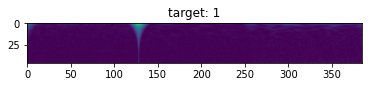

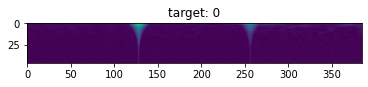

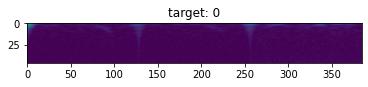

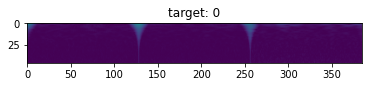

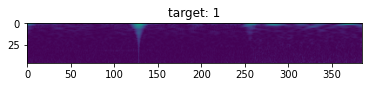

CPU times: user 5.37 s, sys: 391 ms, total: 5.77 s
Wall time: 5.23 s


In [28]:
%%time
for i in range(5):
    waves = np.load(df.iloc[i].id)
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = qtfm()(waves)
    target = get_label(train_files[i])
    plt.imshow(image[0])
    plt.title(f"target: {target}")
    plt.show()

Cool! so we are able to plot the images now. IT is fast too.

## Creating the dataset🖫
If you want to use fastai's learner to train your model on the transfomed spectograms, you can do so by creating a custom Dataset in pytorch and then feeding that dataset with a dataloader to fastai's learner. However, if you create a pipeline using fastai's internals then you get to use some cool functionalities out-of-box. We will see that in a while.

All the code below are very heavily insipired by the original inspiration of this notebook (see the very first section), this [post](https://ohmeow.com/posts/2020/04/11/finding-datablock-nirvana-part-1.html) by Wayde Gilliam and the fastai s[iamese tutorial](https://docs.fast.ai/tutorial.siamese.html#Writing-your-custom-data-block).

## Spectogram

In [29]:
#export
def get_waves(f):
    """read numpy file, stack the timeseries and convert those into a tensor"""
    waves = np.load(f)
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    return waves

def create_spectrogram(x: Path):
    """Create an AudioSpectrogram from a torch tensor"""
    waves = get_waves(x)
    return qtfm()(waves)

## NNAudioImage(fastuple)
First of all, we are going to create an "Image type" for our transformed object (it's the numpy data transformed into spectrogram). 

We have to do this because our data is not an image data from get-go. Rather it's a signal data which we are transforming into an Image.  So, to tell fastai that this is a custom Image type which we are dealing with and ho we should be displaying it, we have to create an Image type.

In [30]:
#export
class AudioImage(fastuple):
    """Custom Image for nnAudio transformed signals"""
    def show(self, figsize=None, ctx=None, **kwargs):
        if len(self) > 1:
            img,label = self
        else:
            img = self
            label = ''
    
        if figsize is None: figsize=(10,10)
        return show_image(img, 
                          title=label, figsize=figsize, ctx=ctx)

In [31]:
image = create_spectrogram(train_files[0])

In [32]:
type(image), image.shape

(torch.Tensor, torch.Size([1, 46, 385]))

In [33]:
image

tensor([[[0.3868, 0.3814, 0.3670,  ..., 0.1262, 0.1258, 0.1258],
         [0.3012, 0.2917, 0.2653,  ..., 0.1504, 0.1565, 0.1585],
         [0.2445, 0.2453, 0.2446,  ..., 0.0945, 0.0961, 0.0965],
         ...,
         [0.0027, 0.0040, 0.0072,  ..., 0.0018, 0.0076, 0.0014],
         [0.0027, 0.0040, 0.0120,  ..., 0.0012, 0.0061, 0.0126],
         [0.0039, 0.0140, 0.0172,  ..., 0.0010, 0.0064, 0.0160]]])

In [34]:
get_label(train_files[0])

1

<AxesSubplot:title={'center':'1'}>

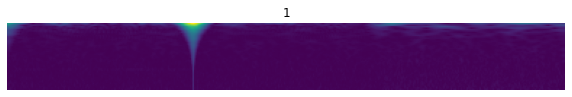

In [35]:
s = AudioImage(image, get_label(train_files[0]))
s.show()

## NNAudioDataset
You can create a Dataset in fastai by creating a custom Transform . Creating a `Transform` has come advantages as compared to a pytorch Dataset. For example, you don't need to have a `len` component or a `get_item` component.

On a very high level a `Transform` has an `encodes`, `decodes` and `setup` methods. For our purpose having an `encodes` methods only would suffice. This is the place where we would be transforming the numpy data into spectograms.

To know more about `Tranforms` refer these -->
* [data block nirvana](https://ohmeow.com/posts/2020/04/11/finding-datablock-nirvana-part-1.html)
* [Siamese tutorial](https://docs.fast.ai/tutorial.siamese.html#Writing-your-custom-data-block)
* [Fastbook chapter-11](https://github.com/fastai/fastbook/blob/master/11_midlevel_data.ipynb)
* [Albumentation tutorial](https://docs.fast.ai/tutorial.albumentations.html)

In [36]:
%%time
vals = df.target.to_list()

CPU times: user 9.73 ms, sys: 0 ns, total: 9.73 ms
Wall time: 9.74 ms


In [37]:
%%time
vocab,o2i = uniqueify(vals, sort=True, bidir=True)

CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 12.8 ms


In [38]:
lbl2path = mapxy(df)

In [39]:
%%time
lbl2path[train_files[5]]

CPU times: user 13 µs, sys: 5 µs, total: 18 µs
Wall time: 21.5 µs


1

combining all above steps

## NNAudioTransform(ItemTransform)

In [40]:
#export
#ItemTransform let's you work with tuple elements
class NNAudioTransform(ItemTransform):
    """Custom Transform which uses nnAudio transforms
    to extract spectogram on the fly"""
    def __init__(self, df: DataFrame, col: str = 'target'):
        self.lbl2files = mapxy(df)
        vals = df[col].to_list()
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)
        
    def encodes(self, o): return (create_spectrogram(o), self.o2i.get(self.lbl2files.get(o)))
    def decodes(self, x): return AudioImage(x[0],self.vocab[x[1]])

Let's walk through the code.

If you inherit from the `Transform` class, the resulting transform is applied to the item as a whole but when you inherit from the `ItemTransform` class then the resulting transform is applied to each element of the input.

For example, if you have a transform that is inherited from the `Transform` class and you have an input which is a tuple `("a", 1)` then the transform would consider the tuple as a single element. But, when your transform is an `ItemTransform` then the transform is applied to "a" as well as "1" separately. 

The __init__ method sets up our `mapxy` method as a class property. It then converts the target column values into a list and creates a vocab of our targets and a dictionary mapping our targets to indices.

The encodes method is where the magic occurs. Here, we return a tuple with our spectogram and the label related to our input. 

The decodes method returns an `AudioImage` type which knows how to show itself whenever a `show` method is invoked.

You might notice that I have used a dataframe to create a list of our inputs and a dictionary of our labels. This was an engineering choice which I made because creating a list of labels from the input list of filenames was too slow. Doing it this was by using a dataframe  made things faster.

> In deep learning a majority chunk of the speed boost comes from good engineering practices rather than having the best SOTA architectures or a faster computer.

We will also use a 'splitter' which tells fastai the way we want to split our data. For now we will use `RandomSplitter` to do this job. Additionally we will also instantiate the `NNAudioTransform` object.

We will take a few samples only to make our experiment quicker.

In [41]:
subset_for_dsets = train_files[:20000]

In [42]:
splits = TrainTestSplitter()(subset_for_dsets)
tfm = NNAudioTransform(df)

The `tfm` is a transform is would be applied to the input files to generate the spectogram. The second list has the transform which will be applied to our targets. 

Next, we have to tell fastai to take our 'sample' and apply the transform and the splitter to it.

In [43]:
%%time
tls = TfmdLists(subset_for_dsets, tfm, splits=splits)

CPU times: user 85 ms, sys: 278 µs, total: 85.3 ms
Wall time: 105 ms


`TfmdLists` is a low-level API which creates a pipeline for us. It creates a pipeline that takes in our samples-->splits it --> applies our transform to the items.

More information on a `TfmdLists` can be found in this [tutorial](https://docs.fast.ai/tutorial.pets.html) fromt he official documentation.

In [44]:
tls.vocab

[0, 1]

<AxesSubplot:title={'center':'0'}>

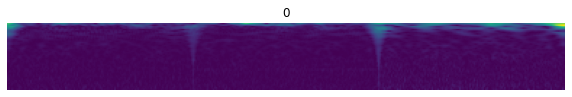

In [45]:
show_at(tls.train, 1)

## Create the Dataloader🖨️
We can use the `TfmdLists` to create a dataloader by calling `dataloaders()`. Here, we can't apply `item_tfms` or `batch_tfms` but we can get the hooks to different point of the pipeline and can put our transforms there.

For example, once items are grabbed then that moment is known as "after_item". We can use this hook to apply our transforms once items are grabbed.

In [46]:
dls = tls.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)])

One more thing that we need to do is to make the `show_batch` method aware of the type of our Image. This can be easily done by using `typedispatch` to dispatch our `show_batch` (the one which we will override with our image type). 

In [47]:
#export
@typedispatch
def show_batch(x:AudioImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=3, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs):
        AudioImage(x[0][i], ['0','1'][x[1][i].item()]).show(ctx=ctx)

`typedispatch` does something similar to [multi-dispatch](https://en.wikipedia.org/wiki/Multiple_dispatch). So, that whenever we call the `show_batch` on our image type then fastai will call our version of `show_batch` after recognizing our image type.

Here we go

CPU times: user 1.05 s, sys: 15.8 ms, total: 1.07 s
Wall time: 1.62 s


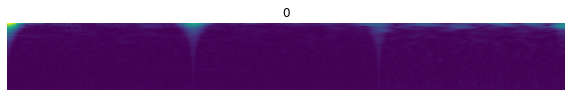

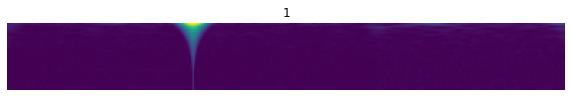

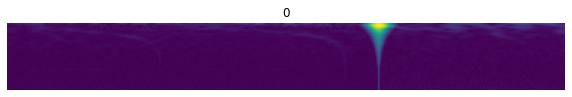

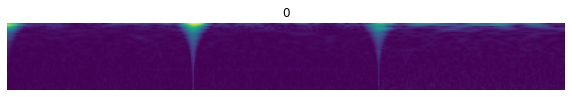

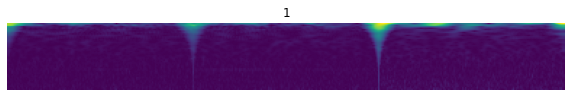

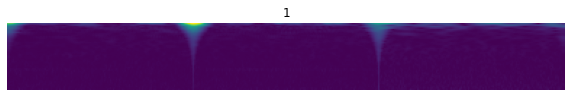

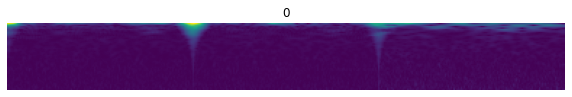

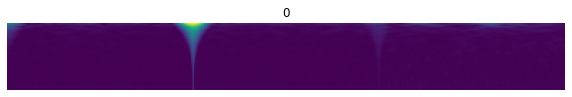

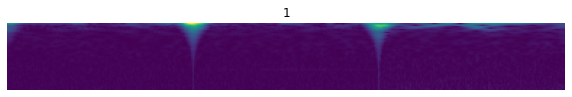

In [48]:
%%time
dls.show_batch()

## Modularity 🧩

The way that we have created the above transform works well for a specific type of task. There are somethings which could not be answered by the above transform.

* What is the categories are other than 0 and 1.
* What if it's a multicategory problem.
* How to handle the lack of targets during inference? 
  * This could be handled by having a `setups` method inside the transform and have it accept list of filenames. This could work well when data is small but for huge data mapping the labelling function to all the filenames in order to create a vocab and label maps would take lots of time. In short it doesn't scale well.
  
So what do we do?

The solution is to create a custom datablock for our type of task which can then be plugged into a `Datablock` like this-->

```
DataBlock(blocks=(NNAudioBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=lambda x:pascal_source/"train"/f'{x[0]}',
                   get_y=lambda x:x[1].split(' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())
```

Let's create a type to represent our spectrogram

In [49]:
class Spectrogram(TensorImageBase):
    """Type to represent a spectogram which knows show itself"""
    @classmethod
    def create(cls, o):
        waves = get_waves(o)
        return cls(qtfm()(waves))
    
    def show(self, figsize=None, ctx=None, **kwargs): 
        t = self
        if not isinstance(t, Tensor): return ctx
        if figsize is None: figsize=(10,10)
        return show_image(t, figsize=figsize, ctx=ctx)

In the above class we use the functions `get_waves` and `qtfm()` defined in the previous sections to create a spectrogram. The `show` method is also similar to the `show` method which we had used in the previous section. The only difference is that in this show method we are not taking the label into account because the `Spectogram` is just a type of a file converted to a spectrogram.

but does it work?  let's test it.

In [50]:
spectrogram = Spectrogram.create(train_files[0])
type(spectrogram)

__main__.Spectrogram

<AxesSubplot:>

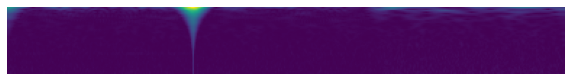

In [51]:
spectrogram.show()

Voila! it knows how to show itself.

Now, we can create a custom block for our data. A block is a set of default transforms which is supposed to be applied to your data in order to tell fastai about the type of your data. 

In our custom block we will tell fastai how create a Spectrogram block and then apply `IntToFloatTensor` transform.

The source code an `ImageBlock` is like this-->

In [52]:
ImageBlock??

We will use the source code for `ImageBlock` to create our custom block.

In [53]:
def SpectrogramBlock(cls=Spectrogram) : 
    "A `TransformBlock` for spectograms of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

Now that we have our custom block ready, we can test if a DataBlock can now be created.

In [54]:
g2net = DataBlock(blocks=(SpectrogramBlock, CategoryBlock),
                   splitter=RandomSplitter(),
                   get_x=ColReader(0),
                   get_y=ColReader(1),
                   batch_tfms=aug_transforms())

Next, we create the dataloader.

In [55]:
dls = g2net.dataloaders(df.iloc[:2000])

/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


CPU times: user 1.19 s, sys: 5.58 ms, total: 1.2 s
Wall time: 1.7 s


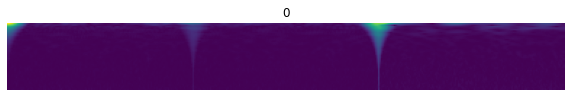

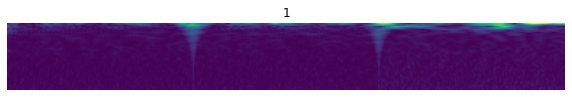

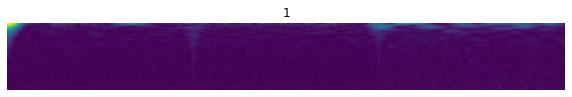

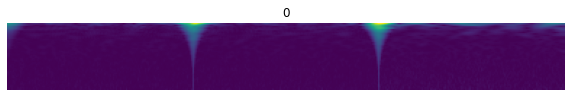

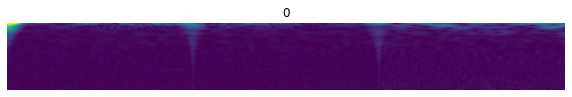

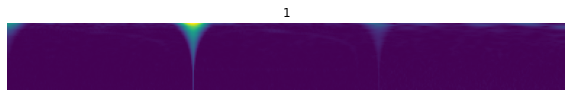

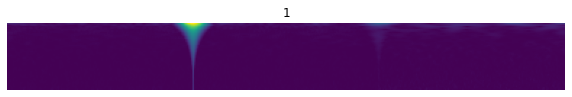

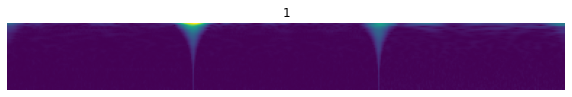

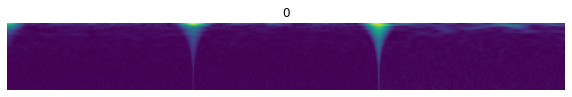

In [56]:
%%time
dls.show_batch()

Here we go. Now we have a custom block and we can create a DataBlock as well as dataloaders and then display it.

## Make your own model🍕
We are going to use the timm library as the source of our model. To weave it into fastai, we will create a custom fastai model.

All the code below is heavily inspired by-->

* [Ayushman's](https://www.kaggle.com/benihime91) [notebook](https://www.kaggle.com/benihime91/fastai-timm-efficientnet-train-fold-0).
* fastai siamese [tutorial](https://docs.fast.ai/tutorial.siamese.html).

We will also take into account the structure of fastai's `create_cnn_model` class. The code for which is as follows

In [57]:
create_cnn_model??

Let's build our own.

We will cut off the head of a timm pretrained model using `create_body` and take the encoder only as this would be the portion of the pretrained model which I would like to use. Then I will top it off with a custom fastai head using `create_head` that we would need to train on our target data.

To know more about this flow have a look into the fastai siamese [tutorial](https://docs.fast.ai/tutorial.siamese.html).

But first we will create our custom `create_body` and `create_head` functions. the reason for this is that fastai in it's current state is not integrated with the timm library. So, creating custom versions of `create_body` and `create_head` makes the weaving of timm into fastai re-usable.

The insipration for this is the [post](https://walkwithfastai.com/vision.external.timm#create_timm_body) in 'walk with fastai'. Once again the code and the approach is based on this post.

> I am recreating this again here instead of using the 'walk with fastai' library is to drill down into the concept and for my personal learning.

## create_timm_body(arch, n_in=3, pretrained=True, cut=None)

In [58]:
#export
def create_timm_body(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained timm library `arch` as determined by `cut`"
    model = create_model(arch, pretrained=pretrained, num_classes=0, in_chans=1,global_pool='')
    _update_first_layer(model, n_in, pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else:  raise NamedError("cut must be either integer or a function")

Now that we have a way to create a body, we will use the code from `create_cnn_model` to build our custom `create_timm_model`.

The code for `create_timm_model` is as follows.

In [59]:
create_cnn_model??

## create_timm_model

In [60]:
create_head?

In [61]:
#export
@delegates(create_head)
def create_timm_model(arch, n_out, pretrained=True, cut=None, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, in_chans=1, **kwargs):
    "Create custom architecture from the timm library"
    body = create_timm_body(arch, n_in, pretrained, None)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

The `@delegate` macro tells fastai to show the parameters of any `**kwargs` (which we would be using in the `create_body`) during function [introspection](https://fastcore.fast.ai/meta.html#delegates).

Let's do a quick test to check if our custom model works.

In [62]:
# num of classes
n_out = 2

In [63]:
model = create_timm_model("efficientnet_b3a", n_out)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [64]:
L(model.children())

(#2) [Sequential(
  (0): Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (

cool! so it works.

Now, we will build a learner which would enable us to do transfer learning with timm models. Once again we will port `cnn_learner` for our use and like before let's quickly take a look into the `cnn_learner` code

In [65]:
cnn_learner??

In [66]:
#export
@delegates(create_timm_model)
def timm_learner(dls, arch, n_out=None, pretrained=True,
                # learner args
                loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                # other model args
                **kwargs):
    "Build a convnet style learner from `dls` and `timm arch`"

    kwargs = {**kwargs}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    model = create_timm_model(arch, n_out, default_split, pretrained, **kwargs)

    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=default_split, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,n_out,pretrained', self=learn, **kwargs)
    return learn

Here we go. We have managed to get a port of the learner code which looks the part. Does it work?

Let me find out.

> To find the list of models available in the timm library use `list_models`

In [67]:
list_models("efficient*")

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_s']

## The learner👩‍🏫
Now that we have the model in place, we can go ahead and create the learner the usual way. We have kept the batch size to default.

There is one little thing that I would like to do before creating a learner. I will create a helper function which can help me to get the suggested learning rate quickly.

In [68]:
#export
def show_me_lrs(learn, num_it:int= 10):
    Suggested_lrs = namedtuple('Suggested_lrs', ["min", "steep",
                                            "valley", "slide"])
    lrs = learn.lr_find(suggest_funcs=(minimum, steep,valley, slide))
    suggested_lrs = Suggested_lrs(lrs[0], lrs[1], lrs[2], lrs[3])
    
    print(f"Minimum/10:\t{lrs[0]:.2e}\
          \nSteepest point:\t{lrs[1]:.2e}\
          \nLongest valley:\t{lrs[2]:.2e}\
          \nSlide interval:\t{lrs[3]:.2e}")
    
    return suggested_lrs

In [69]:
learn = timm_learner(dls, 'efficientnet_b7', loss_func=CrossEntropyLossFlat(), metrics=[RocAucBinary(axis=0)], n_out=2).to_fp16()

Fit one epoch to see how it behaves

In [70]:
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,roc_auc_score,time
0,1.216163,0.700841,0.482039,00:37


In [71]:
#to recover gpu ram
learn.save('epoch1')
learn.load('epoch1')

Using the learning rate finder to get the learning rate

In [72]:
import gc; gc.collect()

66411

/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudi

Minimum/10:	1.00e-06          
Steepest point:	1.10e-06          
Longest valley:	6.92e-06          
Slide interval:	4.37e-03


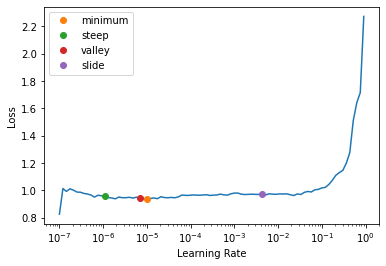

In [73]:
suggested_lrs = show_me_lrs(learn)
#learn.lr_find(suggest_funcs=(minimum, steep,valley, slide))

I will use the slide algorithm here to get the optimal learning rate.

In [74]:
learn.unfreeze()
learn.fit_one_cycle(3, suggested_lrs.slide)

epoch,train_loss,valid_loss,roc_auc_score,time
0,1.114650,1.825437,0.465078,00:36
1,1.011949,0.750606,0.491870,00:37
2,0.917761,0.708508,0.516685,00:37


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
/opt/conda/lib/python3.7/site-packages/nnAudi

Ok! The performance is not that great but the goal of this exercise was not to have a SOTA model but rather to learn how to create a custom code base by using Fastai internals.

However, with proper data augmentation and more data the performance can be much better.

In [75]:
learn.export("./final")

## Inference🧐
For inference you will need to use the previous dataloader to create a test dataloader by passing the test files to it.

In [76]:
%%time
test_path = path/'g2net-gravitational-wave-detection/test'
test_files = getfiles(test_path, "npy")

CPU times: user 2.65 s, sys: 1.22 s, total: 3.86 s
Wall time: 1min 5s


## Inference

For inference we first load the learner

In [77]:
learn = load_learner('./final', cpu=False)

Create a test dataloader. This will take in the test files and apply the transforms that we had created during trainign timebut on the inference data and give you a dataloader.

In [78]:
test_dls = learn.dls.test_dl(test_files[:100])

check the batch

/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


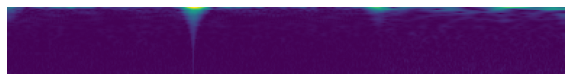

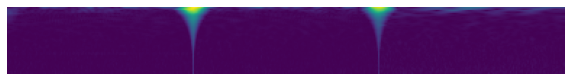

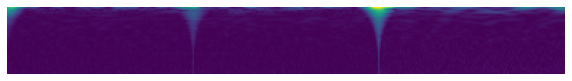

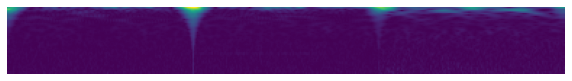

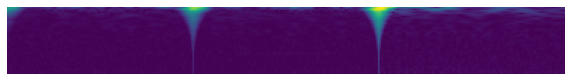

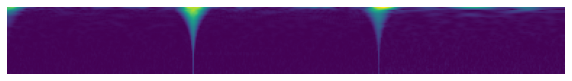

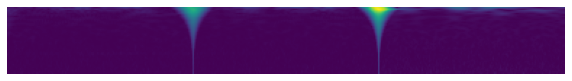

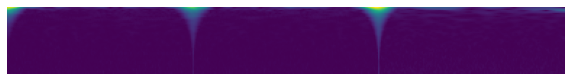

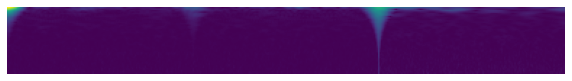

In [79]:
test_dls.show_batch()

Use `get_preds` to get predictions in batches.

In [80]:
preds = learn.get_preds(dl=test_dls)

Have a look at your predictions.

In [81]:
preds

(tensor([[0.5247, 0.4753],
         [0.5247, 0.4753],
         [0.5248, 0.4752],
         [0.5247, 0.4753],
         [0.5252, 0.4748],
         [0.5249, 0.4751],
         [0.4635, 0.5365],
         [0.5260, 0.4740],
         [0.5246, 0.4754],
         [0.5247, 0.4753],
         [0.4650, 0.5350],
         [0.5247, 0.4753],
         [0.5270, 0.4730],
         [0.5247, 0.4753],
         [0.5247, 0.4753],
         [0.4974, 0.5026],
         [0.5246, 0.4754],
         [0.5246, 0.4754],
         [0.5247, 0.4753],
         [0.4956, 0.5044],
         [0.4867, 0.5133],
         [0.4694, 0.5306],
         [0.5264, 0.4736],
         [0.5246, 0.4754],
         [0.5247, 0.4753],
         [0.5247, 0.4753],
         [0.4893, 0.5107],
         [0.4874, 0.5126],
         [0.4887, 0.5113],
         [0.5246, 0.4754],
         [0.5247, 0.4753],
         [0.5246, 0.4754],
         [0.5248, 0.4752],
         [0.5247, 0.4753],
         [0.4840, 0.5160],
         [0.5248, 0.4752],
         [0.5247, 0.4753],
 

## Conclusion
I prepared this post as part of my experimentation for the [g2net-gravitational-wave-detection](https://www.kaggle.com/c/g2net-gravitational-wave-detection) competition. My goal for preparing this notebook was to design an end-to-end flow to learn about extending fastai for a custom new task and how to extend the library to work well with other libraries.

It took quite a long time to get my head around the low-level and mid level API in fastai.

Part of the reason being that I couldn't spend much time on this competition and the other part was that there are very few resources available at this moment which provide good detail about creating custom bits using fastai's mid-level and low-level APIs. 

I would like to say that the effort that it took to complete this post was worth it and I came to know how powerful the modular structure of fastai is.

I would like to create an extension library using the code that I have developed for this post but at this moment I can't say how soon I would be able to do it and when but stay tuned as I would keep posting my progress on this.
